# Convolutions for Botanical Garden Case Study


In this notebook, I explore the purpose of Convolutions, how we can apply them to identify things within images, and the mechanics of the kernel which is essential for all convolutions.

This notebook centers around a botanical garden use case. The owner wants to use pictures of their flowers 🌸 to create molds of flowers and use to create clay models for children to paint.

The focus here and point of the convolution is that there is no easy way to identify where the flowers are in the pictures, this would take a long time to identify and extract for example manually applying bounding boxes. The value here is to help process all the pictures in a way that makes the flowers easy to identify.

## **Overview**

<ol>
    <li><a href="https://#Objectives">Objectives</a></li>
    <li>
        <a href="https://#Setup">Setup</a>
    </li>
    <li>
        <a href="https://#Background">Background</a>
    </li>
</ol>

<a href="https://#Exercises">Process</a>

<ol>
    <li><a href="https://#E1">Step 1: Implementing Edge Detection</a></li>
    <li><a href="https://#E2">Step 2: Implementing Corner/Blob Detection</a></li>
</ol>


## Objectives

*   Explain how a convolution works on images
*   Understand the purposes of different kernels that exist
*   Apply kernels to images and obtain a useful result
*   Streamline the identification of the flower identification

***


<h2 href="Setup">Setup</h2>


### Install Required Libraries

In [ ]:
# Note you will need Python 3.9 or later to run this code due to tendsorflow requirement

# %pip install numpy==1.22.3 matplotlib==3.5.1 tensorflow==2.9.0 opencv-python==4.5.5.62

# RESTART YOUR KERNEL AFTER INSTALLING PACKAGES

### Importing Required Libraries

In [ ]:
# This section is used to suppress warnings generated by code:
def warn(*args, **kwargs):
    pass


import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # tensorflow INFO and WARNING messages are not printed

In [40]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import PIL
from PIL import Image, ImageOps
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import cv2

## Background

As humans, it's quite easy for us to identify petals on a flower. We can see the edges of the petals, the shapes, and count how many there are. It's easy for us to pick them out from a busy picture. This is not the case for computers, which need some extra help when it comes to identifying objects in an image.

Neural networks can mimic this ability using **Convolutions**. Convolutions enable computers to augment an image using matrix multiplication and with some specific kernels (filters), we can do some pretty cool things with them.



### What does a CNN do?

A CNN is a type of neural network which is designed to process image data. It works by moving an $n\times m$ sized kernel (matrix) over an input image and performs element wise multiplication over an $n \times m$ sized portion of your image. In this case, we have an input image of 5x5, and a kernel of 3x3.

<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/images/convolution.png" width="600" alt="convolution example">
</center>

A CNN layer will compute element wise multiplication over a 3x3 window (same size as kernel) on the input image. This means the top left pixel of the input image is multiplied by the top left pixel of the kernel, and so on.

#### What are we computing?

These values are the brightness values of each pixel! They range between 0-255, and in this case because it's just one array, it means we are working with just one channel. Normally this is a grayscale image, whereas a three channel image would have three arrays with values ranging between 0-255 and we would perform convolutions over each channel. That will be discussed in a future lab.

In the end, the multiplied values are all added together to become the top left pixel value of the output image.


### Second step

We now *shift* the kernel one step right on the input image, and recalculate the element wise multiplication of our kernel with the new 3x3 window on the input image. This produces the next pixel value of our output image. The number of pixels we shift by is referred to as the `stride`, and in this example it is `1`.

<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/images/convolution-1.png" width="600" alt="convolution example 2">
</center>

We can continue to shift our window over the input image until we have covered the entire image. Now we will have an output image of 3x3 which we can pass to the next layer. This whole process is known as convolution, which is where Convolutional Neural Networks get their name.


### Size of output image

Notice that the resulting image is 3x3, compared to our input image of 5x5. This is because our kernel is 3x3 and the pixels in the output image are centered around the interior pixels of the input image. For each pixel in our output image, it took in 9 pixels from the input image. For the border pixels in the input image, there are not enough pixels surrounding it to calculate an output value.

We can calculate the output image size using the following formula:

$$M_{out} = M_{in} - (K - 1)$$

Where $M$ represents the width of the input image (it can also represent the height, if our images are square).

In the above example,

$$
M_{in} = 5\\\\\\\\
K = 3 \\\\\\
M_{out} = 5 - (3 - 1) = 3
$$

The final output is shown below.

<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/images/convolution.gif" width="700" alt="convolution example 3">
</center>

### Why do this?

By performing these convolutions, we are able to extract features such as horizontal or vertical lines, edges, and more from an image. For example, the above kernel is known as a Prewitt kernel, mentioned later, and it specifically looks for vertical lines in images.


## Importing data

Lets take a look at the flowers dataset from tensorflow, retrieved from here: [https://www.tensorflow.org/datasets/catalog/tf_flowers](https://www.tensorflow.org/datasets/catalog/tf_flowers?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera35714171-2022-01-01)


In [41]:
dataset_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module3/L1/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)

data_dir = pathlib.Path(data_dir)

for folder in data_dir.glob('[!LICENSE]*'):
    print('The', folder.name, 'folder has',
          len(list(folder.glob('*.jpg'))), 'pictures')
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count, 'total images')

The flower_photos folder has 0 pictures
0 total images


In [42]:
# Define the dataset URL
dataset_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module3/L1/flower_photos.tgz"

# Download and extract the dataset
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)

# Convert the data directory to a pathlib Path object
data_dir = pathlib.Path(data_dir)

# Debugging: Check if the directory exists and list its contents
if not data_dir.exists():
    raise FileNotFoundError(f"The directory {data_dir} does not exist.")
else:
    print(f"The directory {data_dir} exists.")
    print("Contents of the directory:", list(data_dir.iterdir()))

# Check if the nested directory exists
nested_data_dir = data_dir / 'flower_photos'
if not nested_data_dir.exists():
    raise FileNotFoundError(f"The nested directory {nested_data_dir} does not exist.")
else:
    print(f"The nested directory {nested_data_dir} exists.")
    print("Contents of the nested directory:", list(nested_data_dir.iterdir()))

# Iterate over each folder in the nested data directory and count the number of images
for folder in nested_data_dir.glob('[!LICENSE]*'):
    if folder.is_dir():
        print('The', folder.name, 'folder has',
              len(list(folder.glob('*.jpg'))), 'pictures')

# Count the total number of images in the dataset
image_count = len(list(nested_data_dir.glob('*/*.jpg')))
print(image_count, 'total images')

The directory C:\Users\willl\.keras\datasets\flower_photos exists.
Contents of the directory: [WindowsPath('C:/Users/willl/.keras/datasets/flower_photos/flower_photos')]
The nested directory C:\Users\willl\.keras\datasets\flower_photos\flower_photos exists.
Contents of the nested directory: [WindowsPath('C:/Users/willl/.keras/datasets/flower_photos/flower_photos/daisy'), WindowsPath('C:/Users/willl/.keras/datasets/flower_photos/flower_photos/dandelion'), WindowsPath('C:/Users/willl/.keras/datasets/flower_photos/flower_photos/LICENSE.txt'), WindowsPath('C:/Users/willl/.keras/datasets/flower_photos/flower_photos/roses'), WindowsPath('C:/Users/willl/.keras/datasets/flower_photos/flower_photos/sunflowers'), WindowsPath('C:/Users/willl/.keras/datasets/flower_photos/flower_photos/tulips')]
The daisy folder has 633 pictures
The dandelion folder has 898 pictures
The roses folder has 641 pictures
The tulips folder has 799 pictures
3670 total images


Let's extract some images we can use for this lab. We will set them all to be square images of 300x300, and display them as well.


In [43]:
# Define the dataset URL
dataset_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module3/L1/flower_photos.tgz"

# Download and extract the dataset
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)

# Convert the data directory to a pathlib Path object
data_dir = pathlib.Path(data_dir)

# Debugging: Check if the directory exists and list its contents
if not data_dir.exists():
    raise FileNotFoundError(f"The directory {data_dir} does not exist.")
else:
    print(f"The directory {data_dir} exists.")
    print("Contents of the directory:", list(data_dir.iterdir()))

# Check if the nested directory exists
nested_data_dir = data_dir / 'flower_photos'
if not nested_data_dir.exists():
    raise FileNotFoundError(f"The nested directory {nested_data_dir} does not exist.")
else:
    print(f"The nested directory {nested_data_dir} exists.")
    print("Contents of the nested directory:", list(nested_data_dir.iterdir()))

# Iterate over each folder in the nested data directory and count the number of images
for folder in nested_data_dir.glob('[!LICENSE]*'):
    if folder.is_dir():
        try:
            print('The', folder.name, 'folder has',
                  len(list(folder.glob('*.jpg'))), 'pictures')
        except PermissionError as e:
            print(f"PermissionError: {e}")

# Count the total number of images in the dataset
try:
    image_count = len(list(nested_data_dir.glob('*/*.jpg')))
    print(image_count, 'total images')
except PermissionError as e:
    print(f"PermissionError: {e}")

# Example of opening and resizing an image
daisy = list(nested_data_dir.glob('daisy/*.jpg'))
if daisy:
    try:
        img_width, img_height = 150, 150
        pic = Image.open(str(daisy[0])).resize((img_width, img_height))
        pic.show()
    except PermissionError as e:
        print(f"PermissionError: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")
else:
    print("No images found in the 'daisy' folder.")

The directory C:\Users\willl\.keras\datasets\flower_photos exists.
Contents of the directory: [WindowsPath('C:/Users/willl/.keras/datasets/flower_photos/flower_photos')]
The nested directory C:\Users\willl\.keras\datasets\flower_photos\flower_photos exists.
Contents of the nested directory: [WindowsPath('C:/Users/willl/.keras/datasets/flower_photos/flower_photos/daisy'), WindowsPath('C:/Users/willl/.keras/datasets/flower_photos/flower_photos/dandelion'), WindowsPath('C:/Users/willl/.keras/datasets/flower_photos/flower_photos/LICENSE.txt'), WindowsPath('C:/Users/willl/.keras/datasets/flower_photos/flower_photos/roses'), WindowsPath('C:/Users/willl/.keras/datasets/flower_photos/flower_photos/sunflowers'), WindowsPath('C:/Users/willl/.keras/datasets/flower_photos/flower_photos/tulips')]
The daisy folder has 633 pictures
The dandelion folder has 898 pictures
The roses folder has 641 pictures
The tulips folder has 799 pictures
3670 total images


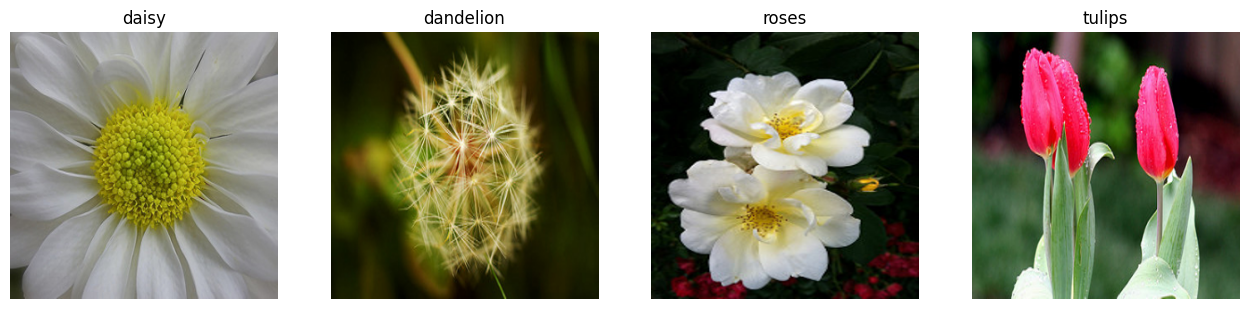

In [44]:
# Initialize lists
pics = list()
pics_arr = list()
p_class = list()

# Image dimensions
img_width = 300
img_height = 300

# Create a figure for plotting
plt.figure(figsize=(20, 5))

# Iterate over each folder in the nested data directory and process images
for idx, folder in enumerate(nested_data_dir.glob('[!LICENSE]*')):
    if folder.is_dir():
        try:
            # Get the list of image files in the folder
            daisy = list(folder.glob('*.jpg'))
            if daisy:
                # Open and resize the first image in the folder
                pic = Image.open(str(daisy[0])).resize((img_width, img_height))
                pic_arr = np.array(pic)
                clss = folder.name

                # Plot the image
                plt.subplot(1, 5, idx + 1)
                plt.imshow(pic)
                plt.title(clss)
                plt.axis('off')

                # Append to lists
                pics.append(pic)
                pics_arr.append(pic_arr)
                p_class.append(clss)
            else:
                print(f"No images found in the folder: {folder.name}")
        except Exception as e:
            print(f"An error occurred while processing the folder {folder.name}: {e}")

# Show the plot
plt.show()

We can see that after importing our images, they're all exactly square with 3200 x 300\` pixels.


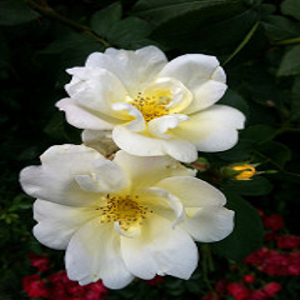

In [45]:
# Lets get an image to use for the rest of the exercises
img = pics[2]
img

## Process: Playing with kernels

Now that we have our images, lets play around with the CNN tools we learned.

In this section, we will see what kernels can do for us. See here for more information: https://en.wikipedia.org/wiki/Feature_(computer_vision)

## Types of kernels

There exist many kernels used in Computer Vision, and we'll explore some of them and see what they do with our images.

### Edge detection Kernels

[**Prewitt Operator**](https://en.wikipedia.org/wiki/Prewitt_operator?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera35714171-2022-01-01)

This computes an approximation of the gradient between pixels in an image. It's commonly used for edge detection.

This operator convolves two kernels with an input image, and then approximates the gradient.

\begin{align\*}
G_x = \begin{bmatrix}
1 & 0 & -1\\\\\\\\
1 & 0 & -1\\\\\\
1 & 0 & -1\\\\\\
\end{bmatrix} * \text{Img} \quad
G_y = \begin{bmatrix}
1 & 1 & 1\\\\\\
0 & 0 & 0\\\\\\
-1 & -1 & -1\\\\\\
\end{bmatrix} * \text{Img}
\end{align\*}

[**Sobel Operator**](https://en.wikipedia.org/wiki/Sobel_operator?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera35714171-2022-01-01)\
The Sobel operator performs edge detection just like the Prewitt operator, except with slightly different kernels.

\begin{align\*}
G_x = \begin{bmatrix}
1 & 0 & -1\\\\\\
2 & 0 & -2\\\\\\
1 & 0 & -1\\\\\\
\end{bmatrix} * \text{Img} \quad
G_y = \begin{bmatrix}
1 & 2 & 1\\\\\\
0 & 0 & 0\\\\\\
-1 & -2 & -1\\\\\\
\end{bmatrix} * \text{Img}
\end{align\*}

Where:
- $G_x$ represents the horizontal gradient approximations;
- $G_y$ represents the vertical gradient approximations;
- Img is the original input image.


To get the edges, we combine the two gradient approximations from above to produce a gradient magnitude $G$ using:

\begin{align\*}
G = \sqrt{G_x^2 + G_y^2}
\end{align\*}

Which will be a pixel value that is large when there is an edge (large change in pixel brightness) and small when there is a smooth transition between pixels.

Lets try to implement the Sobel operator using Keras and Numpy.


<blank>

### Step 1: Implementing Edge Detection


In [46]:
# Lets define our custom kernels for the horizontal and vertical gradients
def v_grad(shape, dtype=None):
    # Here we use a single numpy array to define our x gradient kernel
    grad = np.array([
        [1, 0, -1],
        [2, 0, -2],
        [1, 0, -1]
    ]).reshape((3, 3, 1, 1))
    # this line is quite important, we are saying we want one 3x3 kernel each for one channel of pixels (grayscale)

    # We check to make sure the shape of our kernel is the correct shape
    # according to the initialization of the Convolutional layer below
    assert grad.shape == shape
    return keras.backend.variable(grad, dtype='float32')

def h_grad(shape, dtype=None):
    grad = np.array([
        [1, 2, 1],
        [0, 0, 0],
        [-1, -2, -1]
        ]).reshape((3, 3, 1, 1))

    return keras.backend.variable(grad, dtype='float32')
    assert grad.shape == shape

### Building the Convolutional Neural Network

Here we will build two very simple one layer convolutional neural networks, which will just apply our kernels over an input image. The definition of the function is below.

**keras.layers.Conv2d**

```python
keras.layers.convolutional.Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None, **kwargs)
```


In [47]:
# We define the input layer of our Neural Network
# to take in an image of 300x300 with 1 channel
# Both our models can share this, as it will not change between the two

input_layer = layers.Input(shape=(img_width, img_height, 1))

h_conv = layers.Conv2D(filters=1, # the number of kernels we are using, kernel and filter are interchangeable terms
                       kernel_size=3,
                       kernel_initializer=h_grad,
                       strides=1,
                       padding='valid')  # 'valid' means no padding

v_conv = layers.Conv2D(filters=1,
                       kernel_size=3,
                       kernel_initializer=v_grad,
                       strides=1,
                       padding='valid')


h_model = keras.Sequential([input_layer, h_conv])
v_model = keras.Sequential([input_layer, v_conv])

So we've built a very simple neural network with predefined kernels in our convolutional layer. In practice, there are many ways to initialize your kernels.

Below we have a summary of our model! We can see that there is just a layer that produces a matrix slightly smaller than our input image size of `300x300`, but we also get two matrices which each represent the x and y gradients.


In [48]:
h_model.summary()
v_model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 298, 298, 1)    │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10 (40.00 B)

 Trainable params: 10 (40.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 298, 298, 1)    │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10 (40.00 B)

 Trainable params: 10 (40.00 B)

 Non-trainable params: 0 (0.00 B)

We must convert our RGB image to grayscale, since our CNN models were only designed to apply 1 kernel to 1 channel of input.


In [60]:
import numpy as np
from PIL import ImageOps

# Assuming img, img_width, img_height, h_model, and v_model are already defined

# Convert the image to grayscale
gray = ImageOps.grayscale(img)

# Add 1 dimension to the input image to represent the batch size
input_img = np.array(gray).reshape((1, img_width, img_height, 1))

# Compute the output shape of the first layer of h_model
out_d = h_model.layers[0].compute_output_shape(input_img.shape)[1:]

# Pass the input image into each model and reshape the output
Gx = h_model.predict(input_img).reshape(out_d)
Gy = v_model.predict(input_img).reshape(out_d)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [ ]:
# Now that we have the two gradients,
# try computing our gradient magnitude G using numpy

G = np.sqrt(np.add(np.multiply(Gx, Gx), np.multiply(Gy, Gy)))

Lets look at our image at each step of the process!


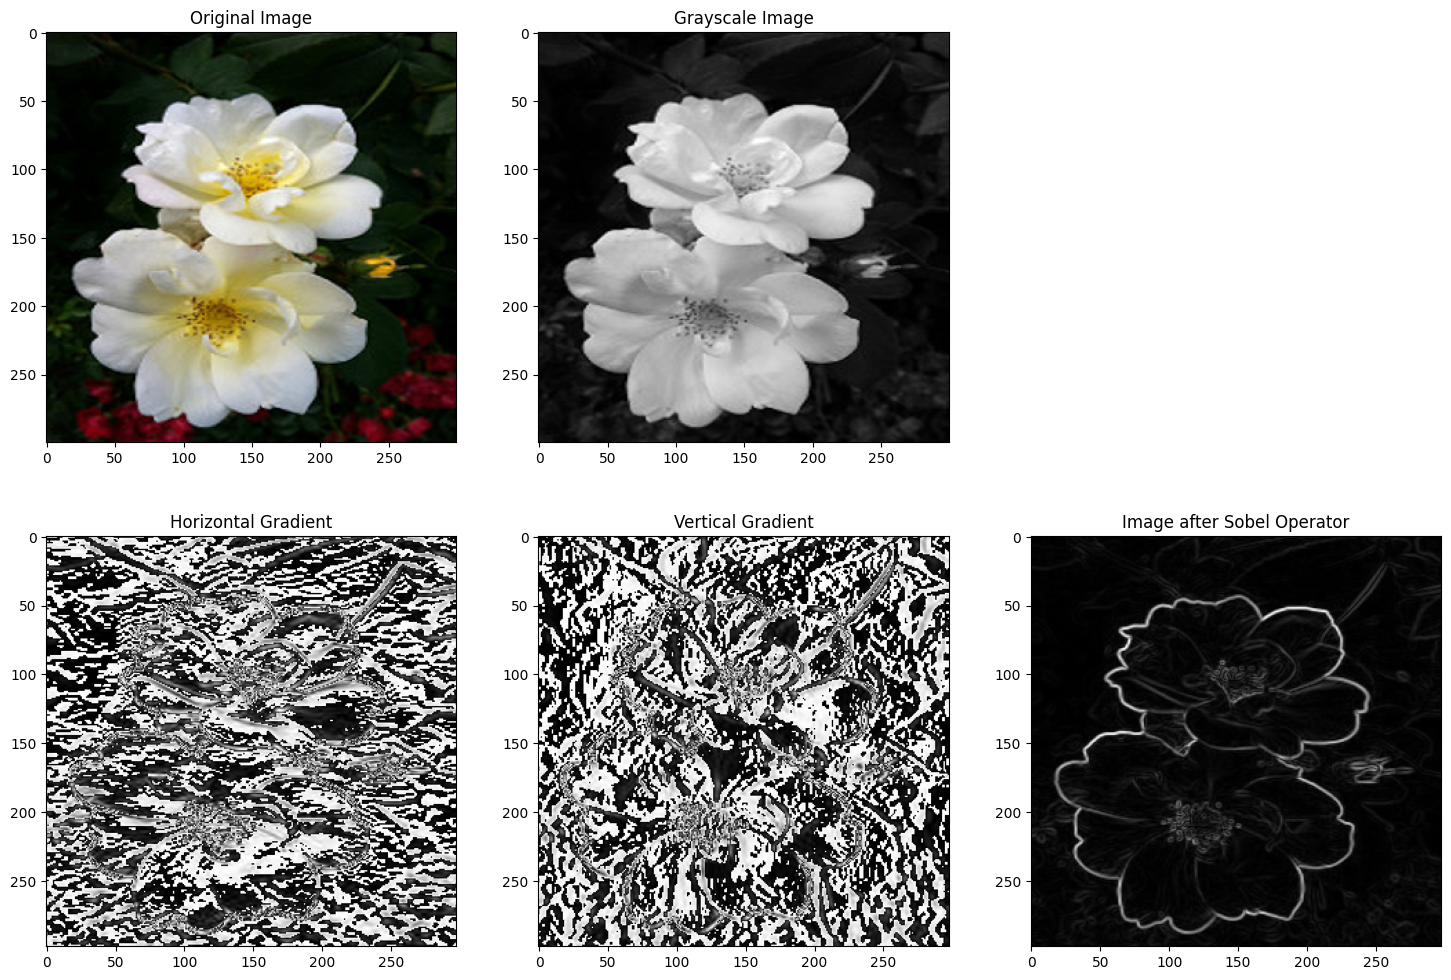

In [62]:
plt.figure(figsize=(18, 12))
plt.subplot(2, 3, 1)
plt.imshow(img)
plt.title("Original Image")
plt.subplot(2, 3, 2)
plt.imshow(gray, cmap=plt.get_cmap('gray'))
plt.title("Grayscale Image")
plt.subplot(2, 3, 4)
plt.imshow(Gx.astype('uint8'), cmap=plt.get_cmap('gray'))
plt.title("Horizontal Gradient")
plt.subplot(2, 3, 5)
plt.imshow(Gy.astype('uint8'), cmap=plt.get_cmap('gray'))
plt.title("Vertical Gradient")
plt.subplot(2, 3, 6)
plt.imshow(G, cmap=plt.get_cmap('gray'))
plt.title("Image after Sobel Operator")
plt.show()

Great, we implemented a simple Prewitt (or Sobel) operator in a Neural Network and use it to detect edges in the image. Recall that these kernels were specifically designed for edge detection in computer vision applications. When you develop your own Convolutional Neural Networks in the future, you will most likely delegate initializing and optimizing the many kernels to Keras and you won't have to define the kernel values manually.

### Step 2: Corner and Blob detection

In computer vision, we can perform corner detection on images which could then be used to extract certain useful features or infer the contents of the image. You can learn more about it [here](https://en.wikipedia.org/wiki/Corner_detection?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera35714171-2022-01-01).

Blob detection is when you want to obtain regions within an image that differ in properties, such as brightness or color. In those regions, properties are relatively constant. You can learn more about this [here](https://en.wikipedia.org/wiki/Blob_detection?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera35714171-2022-01-01).

### [Difference of Gaussians (DoG)](https://en.wikipedia.org/wiki/Difference_of_Gaussians?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera35714171-2022-01-01)

This is a method for both corner *and* blob detection. The way it works is by convolving two Gaussian kernels with different variances (sigma) over an image which will produce two blurred versions of the input image. We then subtract the two blurred images and get the resulting DoG processed image which should make it easy to identify corners and blobs.

The convolution can be illustrated with the following equation:

\begin{align\*}
\Gamma \_{\sigma\_1 ,sigma\_2 }(x,y)=
I \cdot \frac {1}{2\pi \sigma\_1^{2}} e^{ - \frac {x^{2}+y^{2}}{2\sigma\_1^{2}} } -
I \cdot \frac {1}{2\pi \sigma\_2^{2}} e^{ - \frac {x^{2}+y^{2}}{2\sigma\_2^{2}} }
\end{align\*}

Where

*   the first term represents the image convolved with the first Gaussian with mean $0$, variance $\sigma\_1^2$ and
*   the second term represents the image convolved with the second Gaussian with mean $0$, variance $\sigma\_2^2$.

Note that $\sigma\_2^2 > \sigma\_1^2$.


There are built in methods such as scipy's `scipy.ndimage.filters.gaussian_filter` or OpenCV's `cv2.GuassianBlur` which can perform the convolution with a gaussian kernel for you.

We can implement the `cv2.GuassianBlur` function here!


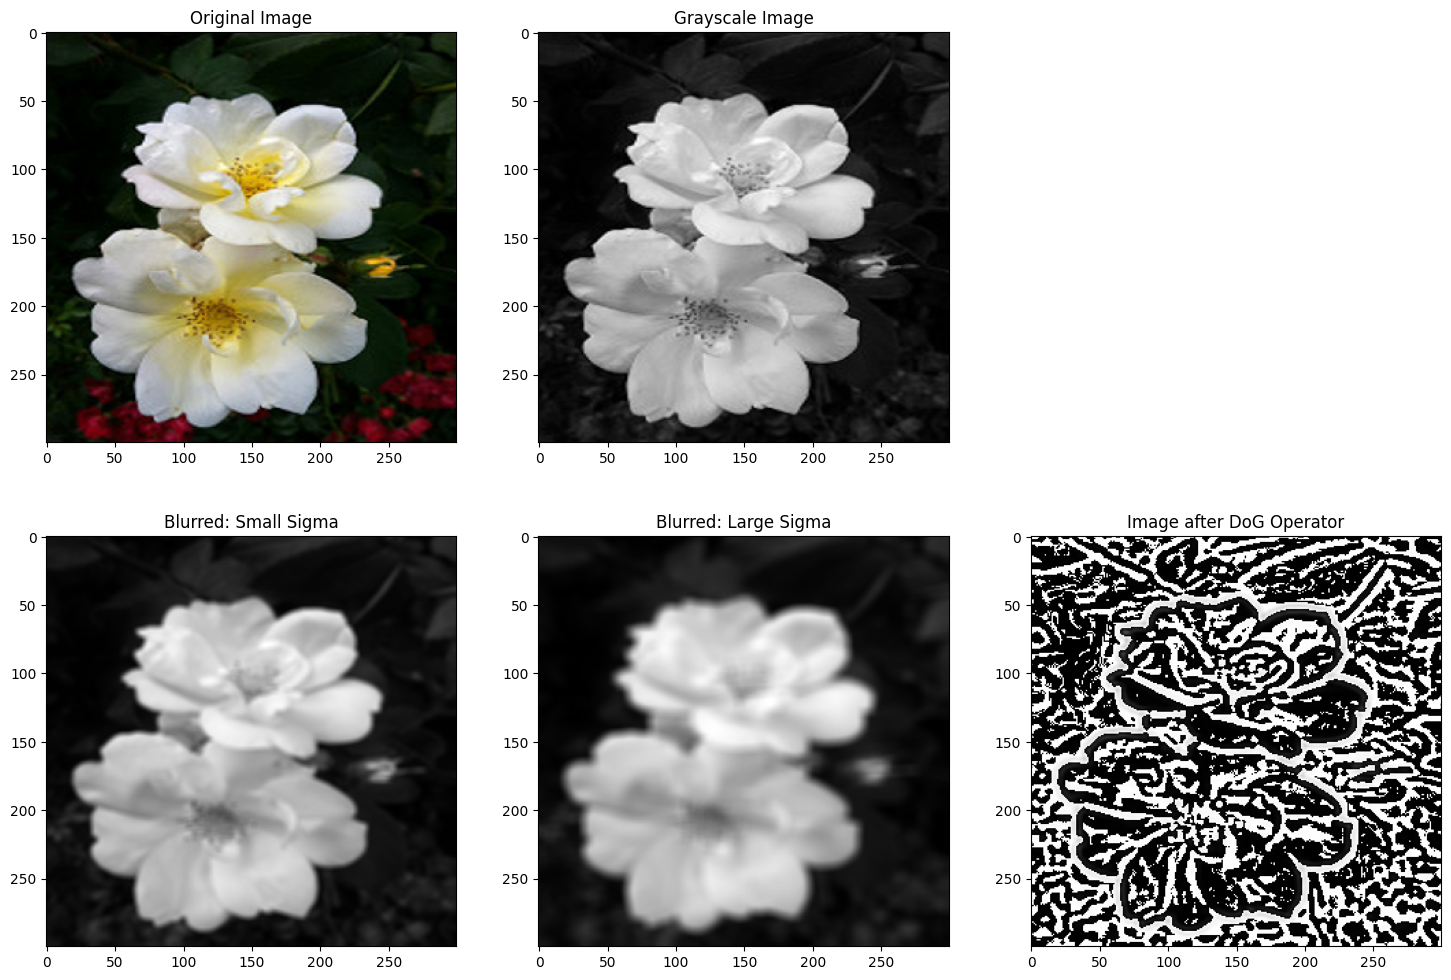

In [63]:
sigma_sm = 5
sigma_lg = 9
blurred_sm = cv2.GaussianBlur(np.array(gray), (sigma_sm, sigma_sm), sigma_sm)
blurred_lg = cv2.GaussianBlur(np.array(gray), (sigma_lg, sigma_lg), sigma_lg)

DoG = blurred_sm - blurred_lg

plt.figure(figsize=(18, 12))
plt.subplot(2, 3, 1)
plt.imshow(img)
plt.title("Original Image")
plt.subplot(2, 3, 2)
plt.imshow(gray, cmap=plt.get_cmap('gray'))
plt.title("Grayscale Image")
plt.subplot(2, 3, 4)
plt.imshow(blurred_sm.astype('uint8'), cmap=plt.get_cmap('gray'))
plt.title("Blurred: Small Sigma")
plt.subplot(2, 3, 5)
plt.imshow(blurred_lg.astype('uint8'), cmap=plt.get_cmap('gray'))
plt.title("Blurred: Large Sigma")
plt.subplot(2, 3, 6)
plt.imshow(DoG.astype('uint8'), cmap=plt.get_cmap('gray'))
plt.title("Image after DoG Operator")
plt.show()

We've now seen how Difference of Gaussians can help us identify the outlines (corners and edges) of objects as well as blobs (areas with very similar properties) very clearly. These methods were all applied by convolving specific kernels over images! I hope this lab has given you a good understanding of how convolutions work, the types of kernels used for specific applications, and why they're useful.


With Difference of Gaussians, we can greatly enhance features within an image by applying two Gaussian kernels to the same image, and take their difference. This technique greatly helps in reducing noise in an image, and results in clearly defined corners of shapes, as well as easily identifiable blobs (regions with very similar properties).

Feel free to play around with the kernel sizes and values for `sigma_sm` and `sigma_lg` to see how those values can change our output image.


And thats it! Hopefully you gained a better understanding of image convolutions through this notebook, some important kernels (filters) used in computer vision and why they are useful. You now know how we can implement them using Keras as well.

## Other kernels

This table is from [wikipedia](https://en.wikipedia.org/wiki/Feature_(computer_vision)#Detection), which shows all the different types of methods you can use to process images and detect different features within.

|              Feature detector             | Edge | Corner | Blob | Ridge |
|:-----------------------------------------:|:----:|:------:|:----:|:-----:|
| Canny                                     |  Yes |   No   |  No  |   No  |
| Sobel                                     |  Yes |   No   |  No  |   No  |
| Harris & Stephens / Plessey               |  Yes |   Yes  |  No  |   No  |
| SUSAN                                     |  Yes |   Yes  |  No  |   No  |
| Shi & Tomasi                              |  No  |   Yes  |  No  |   No  |
| Level curve curvature                     |  No  |   Yes  |  No  |   No  |
| FAST                                      |  No  |   Yes  |  Yes |   No  |
| Laplacian of Gaussian                     |  No  |   Yes  |  Yes |   No  |
| Difference of Gaussians                   |  No  |   Yes  |  Yes |   No  |
| Determinant of Hessian                    |  No  |   Yes  |  Yes |   No  |
| Hessian strength feature measures         |  No  |   Yes  |  Yes |   No  |
| MSER                                      |  No  |   No   |  Yes |   No  |
| Principal curvature ridges                |  No  |   No   |  No  |  Yes  |
| Grey-level blobs                          |  No  |   No   |  Yes |   No  |

## Applying our knowledge to the botanical garden

Armed with this knowledge, how would you help the botanical garden process their images to create clay molds?

I would use the image produced by the Sobel operator, as it gives us a cleaner image to work with so kids can easily paint each section.
